<a href="https://colab.research.google.com/github/ManilShrestha/IntelImageClassification/blob/main/intel_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
# Importing required libraries
from collections import OrderedDict
from torchvision import datasets, transforms, models
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import torch
from torch import nn, optim
from PIL import Image
from datetime import datetime


In [10]:
# Setting up the directory where images are located for three sets: training, validation, testing
# Data are store in google drive. It is mounted to this collab book
training_dir = '/content/drive/MyDrive/ColabNotebooks/IntelImageClassification/seg_train/seg_train'
validation_dir = '/content/drive/MyDrive/ColabNotebooks/IntelImageClassification/seg_val/seg_val'
testing_dir = '/content/drive/MyDrive/ColabNotebooks/IntelImageClassification/seg_test/seg_test'

In [11]:
# Define transforms for the training, validation, and training sets
# Training data is transformed for rotation and horizontal flip so that it can generalize
training_transforms = transforms.Compose([ transforms.Resize(150)
                                        , transforms.CenterCrop(150)
                                        , transforms.RandomRotation(30)    # Does random 30 degrees rotations
                                        , transforms.RandomHorizontalFlip()  # Does random horizontal flips to the image
                                        , transforms.ToTensor()   # Converts the image into tensor array
                                        , transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])  # Mean and standard deviation, 3 values for the number of channels
                                                                                                         # Values are for the pretrained models from imagenet dataset, using these for transfer learning is okay
                                        ])

validation_transforms = transforms.Compose([ transforms.Resize(150)
                                            , transforms.CenterCrop(150)
                                            , transforms.ToTensor()
                                            , transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
                                            ])

testing_transforms = transforms.Compose([ transforms.Resize(150)
                                         , transforms.CenterCrop(150)
                                         , transforms.ToTensor()
                                         , transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
                                        ])

In [12]:
# Load the datasets from using datasets.ImageFolder is a generic data loader where the images are arranged in folder structure separated by each class
training_dataset = datasets.ImageFolder(training_dir, transform=training_transforms)
validation_dataset = datasets.ImageFolder(validation_dir, transform = validation_transforms)
test_dataset = datasets.ImageFolder(testing_dir, transform=testing_transforms)

In [13]:
# Defining dataloaders for training, validation and testing. The batch size determines the number of images sent into model at a time
train_loader = torch.utils.data.DataLoader(training_dataset, batch_size=32, shuffle=True)
validate_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=32)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32)

In [14]:
# Transfer learning from torchvision's pre given model vgg16
cnn_model = models.vgg16(pretrained=True)
cnn_model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [15]:
# Freeze the pretrained model parameters. We need the pretrained feature parameters, but need to change the classifier part
for p in cnn_model.parameters():
  p.requires_grad = False

# Build a custom classifer
my_classifier = nn.Sequential(OrderedDict([('Linear1_Transform', nn.Linear(25088, 8000))   # Takes in 25088 input points from the pretrained VGG model, performs linear transformation and gives 8000 output points
                                        , ('ReLU1_Activation', nn.ReLU())              # Rectified Linear Unit activation
                                        , ('Dropout1', nn.Dropout(p = 0.5))            # randomly zeroes some of the elements of the input tensor with probability of 0.5 using samples from a Bernoulli distribution
                                        , ('Linear2_Transform', nn.Linear(8000,6))    # Linear transform, from 8000 input points to 1000 points
                                        # , ('ReLU2_Activation', nn.ReLU())              # Second Rectified Linear Unit activation
                                        # , ('Dropout2', nn.Dropout(p = 0.5))            # randomly zeroes some of the elements of the input tensor with probability of 0.5 using samples from a Bernoulli distribution
                                        # , ('Linear3_Transform', nn.Linear(1000,6))    # Third linear transform, from 1000 input points to 6 points
                                        , ('LogSoftmaxOutput', nn.LogSoftmax(dim=1))  # Log Softmax activation
                                        ]))

cnn_model.classifier = my_classifier    # Assign the newly created classifier as the classifier for the model

cnn_model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [16]:
# Loss function definition and gradient descent
loss_function = nn.NLLLoss()                # Negative log likelihood loss function   -> Might need to create one for the project
sgd_optimizer = optim.SGD(cnn_model.classifier.parameters(),lr = 0.001, momentum=0.9)  # Stochastic Gradient Descent with momentum of 0.9
adam_optimizer = optim.Adam(cnn_model.classifier.parameters(), lr = 0.001)     # Adam is an algorithm for first-order gradient-based optimization of stochastic objective functions, based on adaptive estimates of lower-order moments
rms_prop_optimizer = optim.RMSprop(cnn_model.classifier.parameters(), lr = 0.001) # Implements Adagrad algorithm

In [17]:
# Evaluation of the model, 
def evaluate(cnn_model, validate_loader, loss_function):

  loss = 0
  accuracy = 0

  for images, labels in iter(validate_loader):
    images, labels = images.to('cuda'), labels.to('cuda')   # To operate on GPU, need to mention CUDA
    
    # Get the output from the given images
    output = cnn_model.forward(images)                # Pass the image batch into model and capture output
    loss += loss_function(output, labels).item()  # Calculate the loss based on the loss_function passed as a parameter

    probability = torch.exp(output)             # Probability is the exponential of output since, output is log softmax

    is_equal = (labels.data == probability.max(dim=1)[1])  # Checks if the labelled data is equal to the model prediction

    accuracy += is_equal.type(torch.FloatTensor).mean()      # Accuracy is sum of mean of equality over the batch sample

  return loss, accuracy

In [18]:
current_time = datetime.now().strftime("%H:%M:%S")
print("Start Time =", current_time)
for images, labels in iter(train_loader):
  print(labels)
  break

current_time = datetime.now().strftime("%H:%M:%S")
print("End Time =", current_time)

Start Time = 16:23:07
tensor([4, 1, 5, 1, 5, 3, 5, 0, 5, 0, 3, 3, 5, 1, 3, 2, 2, 3, 1, 3, 2, 1, 5, 4,
        0, 0, 3, 0, 5, 0, 4, 1])
End Time = 16:23:21


In [19]:
# Setting up index and their actual names
%pwd
import json
with open('/content/drive/MyDrive/ColabNotebooks/IntelImageClassification/class_index.json', 'r') as f:
  class_names = json.load(f)

print(len(class_names), class_names)

6 {'0': 'buildings', '1': 'forest', '2': 'glacier', '3': 'mountain', '4': 'sea', '5': 'street'}


In [20]:
# This function saves the trained model so that retraining is not required everytime classifier needs to be used.
def save_trained_model(cnn_model, filepath=None):
  if filepath:
    path = filepath + '/trained_model.data'
  else:
    path = 'trained_model.data'
  
  # Storing actual class name and the indices created by pytorch for the model training
  cnn_model.class_to_idx = training_dataset.class_to_idx

  # Model info as dictionary
  model_info = {'architecture':"vgg16"
                , 'class_to_idx': cnn_model.class_to_idx
                , 'model_state_dict': cnn_model.state_dict()
                }
  torch.save(model_info, path)

In [21]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Mon May 31 16:23:29 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Adam Optmizer:
# Run time: 14:32:41 - 14:18:22 = 0:24:19
# Epoch size: 10
# This function trains the model based on training data
def train_classifier_adam():
  # Set up hyper parameters
  total_epochs = 10
  steps = 0

  # Training start time
  current_time = datetime.now().strftime("%H:%M:%S")
  print("Start Time =", current_time)

  cnn_model.to('cuda')    # Making the model run on GPU
  
  for epoch in range(total_epochs):   # Will iterate through epochs
    cnn_model.train()         # Set model to training mode
    cumulative_loss = 0     # This variable stores the total loss for each epoch until it is printed

    for image_batch, label_batch in iter(train_loader):
      steps += 1
      #print(steps)
      image_batch, label_batch = image_batch.to('cuda'), label_batch.to('cuda')
      adam_optimizer.zero_grad()     # we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes

      output = cnn_model.forward(image_batch)  # Pass the image batch into model
      loss = loss_function(output, label_batch)  # It is a NLLLoss, a negative log likelihood loss function

      loss.backward()   # loss.backward() computes dloss/dx for every parameter x which has requires_grad=True. These are accumulated into x.grad for every parameter x.
      adam_optimizer.step()  # optimizer.step performs a parameter update based on the current gradient (stored in .grad attribute of a parameter) and the update rule

      cumulative_loss += loss.item()    # item() method extracts the loss’s value as a Python float. Cumulative loss accumulates sum of running loss over each epoch

      if steps%25 == 0:
        print("Batch Running: {}".format(steps * 64))

    cnn_model.eval()      # Turn model into evaluation mode
    
    # Turning off gradients for evaluation of the model
    with torch.no_grad():
      validation_loss, accuracy = evaluate(cnn_model, validate_loader, loss_function)     # Based on parameters passed, calculate validation loss and accuracy on validation dataset

      print("Epoch: {} of {}".format(epoch + 1, total_epochs),                                 # Epoch number
      "Training NLL Loss: {:.3f}".format(cumulative_loss/len(train_loader)),                 # Average training loss
      "Validation NLL Loss: {:.3f}".format(validation_loss/len(validate_loader)),   # Average validation loss: validation loss divided by total validation data set size
      "Validation Accuracy: {:.3f}".format(accuracy/len(validate_loader)))      # Average accuracy
      
      cumulative_loss = 0    # Reset running loss
      cnn_model.train()       # Turn back training mode

    steps = 0
  # Training end time
  current_time = datetime.now().strftime("%H:%M:%S")
  print("End Time =", current_time)

train_classifier_adam()

# Saving the trained CNN model into file 
save_trained_model(cnn_model,'/content/drive/MyDrive/ColabNotebooks/IntelImageClassification')

Start Time = 14:18:22
Batch Running: 1600
Batch Running: 3200
Batch Running: 4800
Batch Running: 6400
Batch Running: 8000
Batch Running: 9600
Batch Running: 11200
Batch Running: 12800
Batch Running: 14400
Batch Running: 16000
Batch Running: 17600
Batch Running: 19200
Batch Running: 20800
Batch Running: 22400
Batch Running: 24000
Batch Running: 25600
Batch Running: 27200
Epoch: 1 of 10 Training NLL Loss: 1.713 Validation NLL Loss: 0.704 Validation Accuracy: 0.885
Batch Running: 1600
Batch Running: 3200
Batch Running: 4800
Batch Running: 6400
Batch Running: 8000
Batch Running: 9600
Batch Running: 11200
Batch Running: 12800
Batch Running: 14400
Batch Running: 16000
Batch Running: 17600
Batch Running: 19200
Batch Running: 20800
Batch Running: 22400
Batch Running: 24000
Batch Running: 25600
Batch Running: 27200
Epoch: 2 of 10 Training NLL Loss: 0.620 Validation NLL Loss: 0.381 Validation Accuracy: 0.896
Batch Running: 1600
Batch Running: 3200
Batch Running: 4800
Batch Running: 6400
Batch Ru

In [74]:
# SGD Optmizer: 
# Run time: 15:07:03 - 14:56:23 :  0:11:40
# Epoch size: 10
# This function trains the model based on training data
def train_classifier_sgd():
  # Set up hyper parameters
  total_epochs = 10
  steps = 0

  # Training start time
  current_time = datetime.now().strftime("%H:%M:%S")
  print("Start Time =", current_time)

  cnn_model.to('cuda')    # Making the model run on GPU
  
  for epoch in range(total_epochs):   # Will iterate through epochs
    cnn_model.train()         # Set model to training mode
    cumulative_loss = 0     # This variable stores the total loss for each epoch until it is printed

    for image_batch, label_batch in iter(train_loader):
      steps += 1
      #print(steps)
      image_batch, label_batch = image_batch.to('cuda'), label_batch.to('cuda')
      sgd_optimizer.zero_grad()     # we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes

      output = cnn_model.forward(image_batch)  # Pass the image batch into model
      loss = loss_function(output, label_batch)  # It is a NLLLoss, a negative log likelihood loss function

      loss.backward()   # loss.backward() computes dloss/dx for every parameter x which has requires_grad=True. These are accumulated into x.grad for every parameter x.
      sgd_optimizer.step()  # optimizer.step performs a parameter update based on the current gradient (stored in .grad attribute of a parameter) and the update rule

      cumulative_loss += loss.item()    # item() method extracts the loss’s value as a Python float. Cumulative loss accumulates sum of running loss over each epoch

      # if steps%25 == 0:
      #   print("Batch Running: {}".format(steps * 32))

    cnn_model.eval()      # Turn model into evaluation mode
    
    # Turning off gradients for evaluation of the model
    with torch.no_grad():
      validation_loss, accuracy = evaluate(cnn_model, validate_loader, loss_function)     # Based on parameters passed, calculate validation loss and accuracy on validation dataset

      print("Epoch: {} of {}".format(epoch + 1, total_epochs),                                 # Epoch number
      "Training NLL Loss: {:.3f}".format(cumulative_loss/len(train_loader)),                 # Average training loss
      "Validation NLL Loss: {:.3f}".format(validation_loss/len(validate_loader)),   # Average validation loss: validation loss divided by total validation data set size
      "Validation Accuracy: {:.3f}".format(accuracy/len(validate_loader)))      # Average accuracy
      
      cumulative_loss = 0    # Reset running loss
      cnn_model.train()       # Turn back training mode

    steps = 0
  # Training end time
  current_time = datetime.now().strftime("%H:%M:%S")
  print("End Time =", current_time)

train_classifier_sgd()

# Saving the trained CNN model into file 
save_trained_model(cnn_model,'/content/drive/MyDrive/ColabNotebooks/IntelImageClassification')

Start Time = 14:56:23
Epoch: 1 of 10 Training NLL Loss: 0.402 Validation NLL Loss: 0.274 Validation Accuracy: 0.906
Epoch: 2 of 10 Training NLL Loss: 0.344 Validation NLL Loss: 0.255 Validation Accuracy: 0.910
Epoch: 3 of 10 Training NLL Loss: 0.317 Validation NLL Loss: 0.240 Validation Accuracy: 0.908
Epoch: 4 of 10 Training NLL Loss: 0.307 Validation NLL Loss: 0.236 Validation Accuracy: 0.911
Epoch: 5 of 10 Training NLL Loss: 0.282 Validation NLL Loss: 0.269 Validation Accuracy: 0.904
Epoch: 6 of 10 Training NLL Loss: 0.272 Validation NLL Loss: 0.224 Validation Accuracy: 0.919
Epoch: 7 of 10 Training NLL Loss: 0.262 Validation NLL Loss: 0.227 Validation Accuracy: 0.918
Epoch: 8 of 10 Training NLL Loss: 0.257 Validation NLL Loss: 0.230 Validation Accuracy: 0.914
Epoch: 9 of 10 Training NLL Loss: 0.248 Validation NLL Loss: 0.251 Validation Accuracy: 0.905
Epoch: 10 of 10 Training NLL Loss: 0.241 Validation NLL Loss: 0.264 Validation Accuracy: 0.910
End Time = 15:07:03


In [90]:
# RMSProp Optmizer:
# Run time: 16:04:11 - 15:52:51 = 0:11:20
# Epoch size: 10
# This function trains the model based on training data
def train_classifier_rmsprop():
  # Set up hyper parameters
  total_epochs = 10
  steps = 0

  # Training start time
  current_time = datetime.now().strftime("%H:%M:%S")
  print("Start Time =", current_time)

  cnn_model.to('cuda')    # Making the model run on GPU
  
  for epoch in range(total_epochs):   # Will iterate through epochs
    cnn_model.train()         # Set model to training mode
    cumulative_loss = 0     # This variable stores the total loss for each epoch until it is printed

    for image_batch, label_batch in iter(train_loader):
      steps += 1
      #print(steps)
      image_batch, label_batch = image_batch.to('cuda'), label_batch.to('cuda')
      rms_prop_optimizer.zero_grad()     # we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes

      output = cnn_model.forward(image_batch)  # Pass the image batch into model
      loss = loss_function(output, label_batch)  # It is a NLLLoss, a negative log likelihood loss function

      loss.backward()   # loss.backward() computes dloss/dx for every parameter x which has requires_grad=True. These are accumulated into x.grad for every parameter x.
      rms_prop_optimizer.step()  # optimizer.step performs a parameter update based on the current gradient (stored in .grad attribute of a parameter) and the update rule

      cumulative_loss += loss.item()    # item() method extracts the loss’s value as a Python float. Cumulative loss accumulates sum of running loss over each epoch

      # if steps%25 == 0:
      #   print("Batch Running: {}".format(steps * 32))

    cnn_model.eval()      # Turn model into evaluation mode
    
    # Turning off gradients for evaluation of the model
    with torch.no_grad():
      validation_loss, accuracy = evaluate(cnn_model, validate_loader, loss_function)     # Based on parameters passed, calculate validation loss and accuracy on validation dataset

      print("Epoch: {} of {}".format(epoch + 1, total_epochs),                                 # Epoch number
      "Training NLL Loss: {:.3f}".format(cumulative_loss/len(train_loader)),                 # Average training loss
      "Validation NLL Loss: {:.3f}".format(validation_loss/len(validate_loader)),   # Average validation loss: validation loss divided by total validation data set size
      "Validation Accuracy: {:.3f}".format(accuracy/len(validate_loader)))      # Average accuracy
      
      cumulative_loss = 0    # Reset running loss
      cnn_model.train()       # Turn back training mode

    steps = 0
  # Training end time
  current_time = datetime.now().strftime("%H:%M:%S")
  print("End Time =", current_time)

train_classifier_rmsprop()

# Saving the trained CNN model into file 
save_trained_model(cnn_model,'/content/drive/MyDrive/ColabNotebooks/IntelImageClassification')

Start Time = 15:52:51
Epoch: 1 of 10 Training NLL Loss: 13.520 Validation NLL Loss: 1.429 Validation Accuracy: 0.892
Epoch: 2 of 10 Training NLL Loss: 1.001 Validation NLL Loss: 0.772 Validation Accuracy: 0.900
Epoch: 3 of 10 Training NLL Loss: 0.958 Validation NLL Loss: 0.694 Validation Accuracy: 0.910
Epoch: 4 of 10 Training NLL Loss: 0.873 Validation NLL Loss: 1.581 Validation Accuracy: 0.860
Epoch: 5 of 10 Training NLL Loss: 0.778 Validation NLL Loss: 0.659 Validation Accuracy: 0.914
Epoch: 6 of 10 Training NLL Loss: 0.704 Validation NLL Loss: 0.825 Validation Accuracy: 0.889
Epoch: 7 of 10 Training NLL Loss: 0.725 Validation NLL Loss: 0.896 Validation Accuracy: 0.900
Epoch: 8 of 10 Training NLL Loss: 0.655 Validation NLL Loss: 0.894 Validation Accuracy: 0.887
Epoch: 9 of 10 Training NLL Loss: 0.657 Validation NLL Loss: 0.595 Validation Accuracy: 0.914
Epoch: 10 of 10 Training NLL Loss: 0.627 Validation NLL Loss: 0.594 Validation Accuracy: 0.901
End Time = 16:04:11


In [91]:
# Similar to validation() function. But does not calculate loss on the training set.. Just the accuracy of model on test data
# Run stats: 
def accuracy_test(cnn_model, test_loader):

    # Do validation on the test set
    # Setting to evaluation mode
    cnn_model.eval()

    # Changing model to run on GPU
    cnn_model.to('cuda')

    # Turning off gradients for evaluation of the model
    with torch.no_grad():
    
        accuracy = 0
    
        for images, labels in iter(test_loader):
            images, labels = images.to('cuda'), labels.to('cuda')
            output = cnn_model.forward(images)
            probability = torch.exp(output)      # Since last activation is log softmax, need to raise into exponent to get probability
            is_equal = (labels.data == probability.max(dim=1)[1])
            accuracy += is_equal.type(torch.FloatTensor).mean()   # Cumulative mean accuracy per batch
        
        print("Test Accuracy: {}".format(accuracy/len(test_loader)))    
        
        
accuracy_test(cnn_model, test_loader)

Test Accuracy: 0.9065824747085571


In [22]:
# Function that loads and rebuilds the saved model. We need to save the model so that there are no 

def load_trained_model(filepath):
    
    saved_model = torch.load(filepath)
    
    cnn_model = models.vgg16(pretrained=True)

    for p in cnn_model.parameters():
      p.requires_grad = False
    
    cnn_model.class_to_idx = saved_model['class_to_idx']
    
    my_classifier = nn.Sequential(OrderedDict([('Linear1_Transform', nn.Linear(25088, 8000))   # Takes in 25088 input points from the pretrained VGG model, performs linear transformation and gives 8000 output points
                                        , ('ReLU1_Activation', nn.ReLU())              # Rectified Linear Unit activation
                                        , ('Dropout1', nn.Dropout(p = 0.5))            # randomly zeroes some of the elements of the input tensor with probability of 0.5 using samples from a Bernoulli distribution
                                        , ('Linear2_Transform', nn.Linear(8000,6))    # Linear transform, from 8000 input points to 1000 points
                                        # , ('ReLU2_Activation', nn.ReLU())              # Second Rectified Linear Unit activation
                                        # , ('Dropout2', nn.Dropout(p = 0.5))            # randomly zeroes some of the elements of the input tensor with probability of 0.5 using samples from a Bernoulli distribution
                                        # , ('Linear3_Transform', nn.Linear(1000,6))    # Third linear transform, from 1000 input points to 6 points
                                        , ('LogSoftmaxOutput', nn.LogSoftmax(dim=1))  # Log Softmax activation
                                        ]))
    cnn_model.classifier = my_classifier
    
    cnn_model.load_state_dict(saved_model['model_state_dict'])
    
    return cnn_model

cnn_model = load_trained_model('/content/drive/MyDrive/ColabNotebooks/IntelImageClassification/trained_model.data')
print(cnn_model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [56]:
def process_image(image_path):
  ''' Scales, crops, and normalizes a PIL image for a PytTorch model. Preprocessing needs to be identical to the training sets.
   '''
  image = Image.open(image_path)
  #print(image)

  # Resize, thumbnail maintains aspect ratio, first changing the size to 500 by 500
  image.thumbnail((500,500))
  print(image)
  # Now cropping so that the size is 150*150 as the training data set
  margin_l = (image.width - 150)/2   #  Get the crop start at left
  margin_r = margin_l + 150
  margin_b = (image.height - 150)/2  # Get the crop start at bottom
  margin_t = margin_b + 150

  image = image.crop((margin_l, margin_b, margin_r, margin_t))

  # Normalize so that the original 0-255 range is between 0-1
  np_image = np.array(image)/255

  # Z scoring the image pixel range so that it matches the training dataset std and mean
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  np_image = (np_image - mean) / std   # z score

  # Pytorch needs the channel to be the first element in the array but PIL image has channel as third dimension. Re-arranges the numpy array
  np_image = np_image.transpose((2,0,1))

  return np_image

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=150x150 at 0x7F9D8AFC0750>


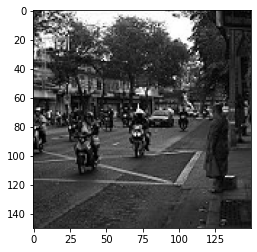

In [57]:
def display_image(image):
  
  figure, axis = plt.subplots()
  # Rearranging the array so that channel is 3 dimension.. Pytorch as channel in first element of the arry, matplotlib has it as third element
  image = image.transpose((1,2,0))

  # Undo z scoring to get actual pixel values in 0-1 range
  mean = np.array([0.485,0.456,0.406])
  std = np.array([0.229,0.224,0.225])
  image = image * std + mean

  # Clipping image to 0-1 range
  # image = np.clip(image,0,1)
  axis.imshow(image)

  return axis

image = process_image('/content/drive/MyDrive/ColabNotebooks/IntelImageClassification/seg_pred/seg_pred/3.jpg')

display_image(image)

In [58]:
def classify (image_path, model):
  '''
  Predict the class of an image using a trained deep learning model
  '''
  # Load the image in path to get numpy array
  image = process_image(image_path)

  # Convert the numpy array to PyTorch tensor
  image = torch.from_numpy(image).type(torch.FloatTensor)

  # Adds an additional dimension to the tensor
  image = image.unsqueeze(0)
  # Pass the image tensor to the model
  output = model.forward(image)

  # Get the probabilites by exponential, since the output is log softmax, need to exp to get accurate output probability
  probabilities = torch.exp(output)

  top_prediction_prob, top_indices = probabilities.topk(6)

  #print(probabilities.topk(6))
  # Get probabilities and ranking tensor predicted by the model
  top_predictions_tensor = top_prediction_prob.detach().type(torch.FloatTensor)
  top_index_rank_tensor = top_indices.detach().type(torch.FloatTensor)

  # Convert tensors into lists
  top_predictions = top_predictions_tensor.numpy().tolist()[0]
  top_index_rank = top_index_rank_tensor.numpy().tolist()[0]

  # print(model.class_to_idx)
  # for key , value in model.class_to_idx.items():
  #   print(key, value)

  # change class-index mapping to index-class mapping so that it can be used to identify the actual class name from index
  index_class = {value: key for key , value in model.class_to_idx.items()}

  classifications = [index_class[index] for index in top_index_rank]

  return top_predictions, classifications

# classification_prob, classes = classify('/content/drive/MyDrive/ColabNotebooks/IntelImageClassification/seg_pred/seg_pred/952.jpg', cnn_model)

prediction_prob, classes = classify('/content/drive/MyDrive/ColabNotebooks/IntelImageClassification/street_1.jpg', cnn_model)
print(prediction_prob)
print(classes)
  


<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x282 at 0x7F9D8AF8E650>
[0.9999998807907104, 8.732578038461725e-08, 1.1160826041134442e-08, 3.4625309286440142e-09, 2.0926108068586302e-12, 7.12947929859542e-13]
['street', 'sea', 'forest', 'buildings', 'glacier', 'mountain']
